In [4]:
pip install joblib
pip install matplotlib
pip install pandas
pip install scikit-learn
pip install numpy
pip install librosa
pip install wave
pip install noisereduce
pip install tqdm

SyntaxError: invalid syntax (1127124335.py, line 2)

In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np

import librosa # wav파일 MFCC 추출
import wave # raw to wav
import noisereduce as nr # 노이즈 감쇄 라이브러리

from tqdm import tqdm # 프로그레스 바 생성
from sklearn import svm # 모델
from sklearn.preprocessing import MinMaxScaler # 스케일러
from sklearn.decomposition import PCA # 주성분 분석

# 1. 경로 설정

In [2]:
# train data 파일이름
train_ctl_path = './fmcc_train.ctl'
# train data .wav 파일 저장 디렉토리 경로
train_data_dir = './raw16k/train/'

# test data 파일이름
test_ctl_path = './fmcc_eval.ctl'
# test data .wav 파일 저장 디렉토리 경로
test_data_dir = './eval/'

# 2. 학습 / 테스트 데이터 읽어오기

In [3]:
# .ctl 파일 입력 함수
def read_ctl_file(file_path):
    with open(file_path, 'r') as f:
        file_list = f.read().splitlines()
    return file_list

# 데이터 리스트 읽어오기
train_list = read_ctl_file(train_ctl_path) 
test_list = read_ctl_file(test_ctl_path)

# 3. RAW To WAV 파일 변환 // wave 라이브러리 사용
   - .wav 파일은 .raw 파일 경로에 저장

In [4]:
# Train
for file_name in tqdm(train_list):
    file_path = os.path.join(train_data_dir, file_name)
    with open(file_path + '.raw', "rb") as inp_f:
        data = inp_f.read()
        with wave.open(file_path + '.wav', "wb") as out_f:
            out_f.setnchannels(1)
            out_f.setsampwidth(2) # number of bytes
            out_f.setframerate(16000)
            out_f.writeframesraw(data)

# Test
for file_name in tqdm(test_list):
    file_path = os.path.join(test_data_dir, file_name)
    with open(file_path + '.raw', "rb") as inp_f:
        data = inp_f.read()
        with wave.open(file_path + '.wav', "wb") as out_f:
            out_f.setnchannels(1)
            out_f.setsampwidth(2) # number of bytes
            out_f.setframerate(16000)
            out_f.writeframesraw(data)

100%|███████████████████████████████████████| 900/900 [00:00<00:00, 3417.70it/s]


# 4. 특징추출

## 4.1. Mel-Spectrogram 특징 추출

In [5]:
def extract_log_mfcc(file_path, roll=0):
    data,sr = librosa.load(file_path,sr=16000)
    # 노이즈 감쇄
    data = nr.reduce_noise(y=data,sr=sr)
    # Mel-Spectrogram 추출
    S =  librosa.feature.melspectrogram(y=data,sr=sr,n_mels = 128,fmax = 8000)
    # MFCC 추출
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc = 100)
    # 데이터 패딩
    pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
    padded_mfcc = pad2d(mfcc, 100)
    return padded_mfcc

In [6]:
train_dataset = np.zeros(shape=(10000, 2), dtype=object)
test_dataset = np.zeros(shape=(900, 2), dtype=object)

In [7]:
# Train
i = 0
for file_name in tqdm(train_list):
    file_path = os.path.join(train_data_dir, file_name)
    audio_path = file_path + '.wav'
    # MEL 특징 추출
    mels = extract_log_mfcc(audio_path) 
    train_dataset[i, 0] = mels
    # 파일명에서 성별 label 추출
    file_info = file_name.split("/")[-1]
    prefix, _ = file_info.split("_")
    train_dataset[i, 1] = prefix[0]
    i += 1

100%|███████████████████████████████████| 10000/10000 [3:28:06<00:00,  1.25s/it]


In [8]:
# Test
i = 0
for file_name in tqdm(test_list):
    file_path = os.path.join(test_data_dir, file_name)
    audio_path = file_path + '.wav'
    # MFCC 특징 추출
    mels = extract_log_mfcc(audio_path)
    feature = mels
    test_dataset[i, 0] = feature
    i += 1

100%|█████████████████████████████████████████| 900/900 [00:29<00:00, 30.43it/s]


In [9]:
# Test label 생성
i = 0
with open('./fmcc_test900_ref.txt', 'r') as file:
    for line in file:
        label = line.strip().split()[-1]
        if label == 'feml':
            test_dataset[i, 1] = 'F'
        else:
            test_dataset[i, 1] = 'M'
        i += 1

FileNotFoundError: [Errno 2] No such file or directory: './fmcc_test900_ref.txt'

## 4.2 데이터셋 저장

In [17]:
np.save("./dataset_train", train_dataset, allow_pickle=True)
np.save("./dataset_test", test_dataset, allow_pickle=True)

## 4.2 데이터 전처리

In [6]:
train_data = pd.DataFrame(np.load("./dataset_train.npy",allow_pickle= True))
test_data = pd.DataFrame(np.load("./dataset_test.npy",allow_pickle= True))

In [7]:
train_data.columns = ['feature', 'label']
test_data.columns = ['feature', 'label']

In [8]:
print(train_data.info())
print(train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  10000 non-null  object
 1   label    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None
(10000, 2)


In [9]:
# 넘파이 배열로 변환
X_train = np.array(train_data.feature.tolist())
y_train = np.array(train_data.label.tolist())
X_test = np.array(test_data.feature.tolist())
y_test = np.array(test_data.label.tolist())

In [10]:
print('X_train, y_train 데이터')
print(X_train.shape)
print('X_test, y_test 데이터')
print(X_test.shape)

X_train, y_train 데이터
(10000, 100, 100)
X_test, y_test 데이터
(900, 100, 100)


In [11]:
# 차원 Reshape
nsamples1, nx1, ny1 = X_train.shape
X_train = X_train.reshape((nsamples1,nx1*ny1))
nsamples2, nx2, ny2 = X_test.shape
X_test = X_test.reshape((nsamples2,nx2*ny2))

In [12]:
print('RESHAPE\n X_train, y_train 데이터')
print(X_train.shape)
print(y_train.shape)
print('X_test, y_test 데이터')
print(X_test.shape)
print(y_test.shape)

RESHAPE
 X_train, y_train 데이터
(10000, 10000)
(10000,)
X_test, y_test 데이터
(900, 10000)
(900,)


### 스케일링을 위해서 학습 데이터를 fit 시킨다.

In [13]:
# 스케일링 - MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# 데이터 셔플
idx = np.arange(X_train_scaled.shape[0])
np.random.shuffle(idx)
X = X_train_scaled[idx]
y = y_train[idx]

In [15]:
print('데이터 셔플 확인')
print(y[:10])

데이터 셔플 확인
['F' 'M' 'M' 'M' 'M' 'M' 'F' 'F' 'M' 'F']


In [16]:
# 데이터 라벨 인코더
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(y)
y_test = lb.fit_transform(y_test)

In [17]:
print('데이터 라벨 인코딩 확인')
print(y[:10])
print('\nSHAPE 확인\nX_train, y_train 데이터')
print(X.shape)
print(y.shape)
print('X_test, y_test 데이터')
print(X_test.shape)
print(y_test.shape)

데이터 라벨 인코딩 확인
[0 1 1 1 1 1 0 0 1 0]

SHAPE 확인
X_train, y_train 데이터
(10000, 10000)
(10000,)
X_test, y_test 데이터
(900, 10000)
(900,)


## 4.3. 데이터 시각화 및 분석

In [18]:
# 테스트 데이터
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(X_test)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성

/var/folders/nk/wf8xl72x1nj4zqkpjtmw6cc00000gn/T/ipykernel_63758/817099317.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.array(principalDf)[:, 0], np.array(principalDf)[:, 1], cmap='bwr')


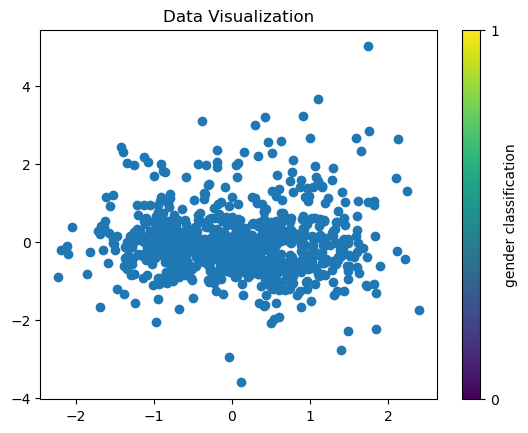

In [20]:
plt.scatter(np.array(principalDf)[:, 0], np.array(principalDf)[:, 1], cmap='bwr')
plt.title('Data Visualization')
plt.colorbar(ticks=[0, 1], label='gender classification')
plt.show()

# 5. 모델 테스트
   
### Test Data : X_test, y_test

In [21]:
# 모델 불러오기
svm_model = joblib.load('./svm_model_기하하학.pkl') 

In [22]:
svm_model.get_params

<bound method BaseEstimator.get_params of SVC(C=10, gamma=0.025, random_state=24, verbose=1)>

In [23]:
labels = svm_model.predict(X_test)

In [24]:
labels

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,

### txt파일로 결과 추출

In [25]:
file = open('./기하하하학_test_results.txt', 'w')
for i in range(0, 900):
    gender = None
    if labels[i] == 0:
        gender = 'feml'
    else:
        gender = 'male'
    file.write(test_list[i] + ' ' + gender + '\n')
file.close()

file = open('./fmcc_test_ref.txt', 'w')
for i in range(0, 900):
    gender = None
    if i < 401:
        gender = 'feml'
    else:
        gender = 'male'
    file.write(test_list[i] + ' ' + gender + '\n')
file.close()